In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'

In [2]:
grid_params = {
    'y_height':     10, 
    'x_width':      10,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

(0, 4)


In [3]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
    else:
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

    # make agent 
    agent_params = sg.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])
    
    run_dict = {}
    run_dict = {
        'NUM_EVENTS':   500,
        'NUM_TRIALS':   1,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

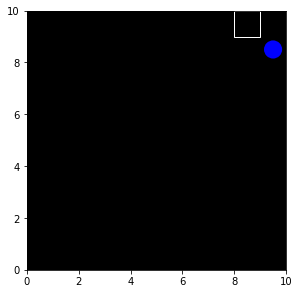

In [4]:
agent_params = {
        'load_model':   False,
        'load_dir':     '../data/outputs/gridworld/run4.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       True,
        'cachelim':     100, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }

gp.plot_env(maze)

In [5]:
run_dict = reset_agt(agent_params)
#expt.run_full_trials(run_dict, pen = -0.0)
expt.run_truncated_trials(run_dict, pen=-0.01, use_EC=True)

[16:12:57]  Trial 1 TotRew = 0.4299999999999997 (0.083s)


../memory/episodic.py:110: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / envelope), 8)


In [13]:
test_key = list(agent_params['EC'].cache_list.keys())[-1]
agent_params['EC'].recall_mem(test_key,1, decay=100)

memory: [[0.00000000e+000 1.79769313e+308]
 [0.00000000e+000 1.79769313e+308]
 [0.00000000e+000 1.79769313e+308]
 [0.00000000e+000 1.79769313e+308]
 [0.00000000e+000 1.79769313e+308]
 [9.35590208e-001 0.00000000e+000]]
deltas: [0.         0.         0.         0.         0.         0.93559021]
times: [1.79769313e+308 1.79769313e+308 1.79769313e+308 1.79769313e+308
 1.79769313e+308 1.00000000e+000]
pvals: [0.      0.      0.      0.      0.      0.99995]


array([0.13247493, 0.13247493, 0.13247493, 0.13247493, 0.13247493,
       0.33762535])

In [ ]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
#trial_length = run_dict['trial_length']
pick = [tot_reward, policy_loss, value_loss]#, trial_length]
#pickle.dump(pick, open("pickles/run1.p", "wb"))

In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

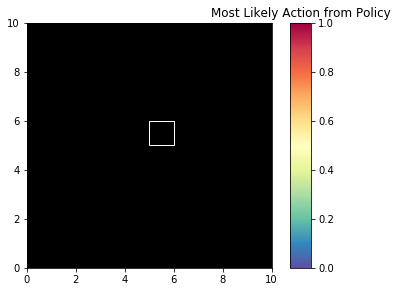

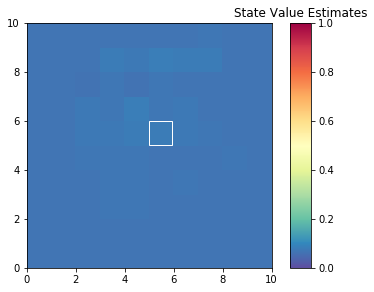

In [19]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range = [0,1])

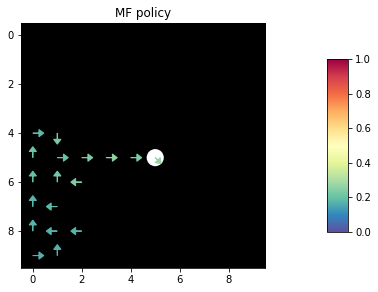

In [30]:
reload(ac)
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=1)
gp.policy_plot(run_dict['environment'],ttt)

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])